In [149]:
from numba import jit
import numpy as np
import time
import timeit
import matplotlib.pyplot as plt

In [141]:
#solid = film[i, j, k, 10][Si, SiF1, SiF2, SiF3, SiO SiO2, SiOF, SiOF2, SiO2F, SiO2F2]
#react_t g[F, O, ion] s  [1,          2,           3,          4,       5 ,   6,    7,    8,   9,  10]
#react_t g[F, O, ion] s  [Si,       SiF1,       SiF2,       SiF3,      SiO, SiO2, SiOF, SiOF2, SiO2F,SiO2F2]

react_table = np.array([[[0.01, 2], [0.01, 3], [0.01, 4], [0.01, -4], [0.05, 7], [0.00, 0], [0.05, 8], [0.00, 0], [0.06, 10], [0.00, 0]],
                        [[0.05, 5], [0.00, 0], [0.00, 0], [0.00, 0], [0.05, 6], [0.00, 0], [0.00, 0], [0.00, 0], [0.00, 0], [0.00, 0]],
                        [[0.27, -1], [0.27, -2], [0.27, -3], [0.27, -4], [0.27, -5], [0.27, -6], [0.27, -7], [0.27, -8], [0.27, -9], [0.27, -10]]])

@jit(nopython=True)
def reaction(parcel, film):
    choice = np.random.rand(parcel.shape[0], react_table.shape[1])
    parcelGen = np.zeros(parcel.shape[0])
    reactList = np.zeros(parcel.shape[0])
    for i in range(parcel.shape[0]):
        acceptList = np.zeros(react_table.shape[1], dtype=np.bool_)
        
        for j in range(film.shape[1]):
            react_rate = react_table[parcel[i], j, 0]
            if react_rate > choice[i, j]:
                acceptList[j] = True
        
        # react_choice_indices = np.random.choice(int(np.sum(acceptList)))
        react_choice_indices = np.where(acceptList)[0]
        # print(react_choice_indices)
        if react_choice_indices.size > 0:
            react_choice = np.random.choice(react_choice_indices)
            reactList[i] = react_choice
            film[i, react_choice] -= 0.01
            react_gen = react_table[parcel[i], react_choice, 1]
            if react_gen > 0:
                film[i, int(react_gen)-1] += 0.01
            else:
                parcelGen[i] = -react_gen
                
    return film, parcelGen, reactList



class UnitTest:
    def __init__(self, parcel, film):
        self.parcel = parcel
        self.film = film
    
    def testReact(self):
        film, parcelGen, reactList = reaction(self.parcel, self.film)
        return film, parcelGen, reactList


film = np.zeros((10, 10))
parcel = np.random.choice(3, size=10)
print(parcel)
# test1 = UnitTest(parcel, film)
# print(test1.testReact())
film, parcelGen, reactList = reaction(parcel, film)
print(film)
print('-------------')
print(parcelGen)
print('---------------')
print(reactList)

[0 1 0 0 2 1 2 2 2 0]
[[ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.   -0.01  0.    0.    0.    0.    0.    0.  ]
 [-0.01  0.    0.    0.    0.01  0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.   -0.01]
 [ 0.    0.    0.    0.    0.   -0.01  0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.   -0.01  0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]]
-------------
[ 0.  0.  0.  0.  4.  0. 10.  6.  7.  0.]
---------------
[0. 0. 0. 0. 3. 0. 9. 5. 6. 0.]


In [124]:
film = np.zeros((1000, 10))
parcel = np.random.choice(3, size=1000)

test1 = UnitTest(parcel, film)
test1.testReact()
numba_time = timeit.timeit(lambda: test1.testReact(), number=100)
print(f"Numba time: {numba_time:.6f} seconds")

Numba time: 1.360035 seconds


In [147]:
film = np.zeros((100, 10))
parcel = np.random.choice(3, size=100)

test1 = UnitTest(parcel, film)
test1.testReact()
numba_time = timeit.timeit(lambda: test1.testReact(), number=10000)
print(f"Numba time: {numba_time:.6f} seconds")


Numba time: 0.320966 seconds


In [131]:
react_table = np.array([[[0.01, 2], [0.01, 3], [0.01, 4], [0.01, -4], [0.05, 7], [0.00, 0], [0.05, 8], [0.00, 0], [0.06, 10], [0.00, 0]],
                        [[0.05, 5], [0.00, 0], [0.00, 0], [0.00, 0], [0.05, 6], [0.00, 0], [0.00, 0], [0.00, 0], [0.00, 0], [0.00, 0]],
                        [[0.27, -1], [0.27, -2], [0.27, -3], [0.27, -4], [0.27, -5], [0.27, -6], [0.27, -7], [0.27, -8], [0.27, -9], [0.27, -10]]])

@jit(nopython=True)
def reaction(parcel, film):
    num_parcels = parcel.shape[0]
    num_reactions = react_table.shape[1]
    choice = np.random.rand(num_parcels, num_reactions)
    parcelGen = np.zeros(num_parcels)
    reactList = np.zeros(num_parcels)

    for i in range(num_parcels):
        acceptList = react_table[parcel[i], :, 0] > choice[i]
        react_choice_indices = np.where(acceptList)[0]
        # print(react_choice_indices)
        if react_choice_indices.size > 0:
            react_choice = np.random.choice(react_choice_indices)
            reactList[i] = react_choice
            film[i, react_choice] -= 0.01
            react_gen = react_table[parcel[i], react_choice, 1]
            if react_gen > 0:
                film[i, int(react_gen) - 1] += 0.01
            else:
                parcelGen[i] = -react_gen
    
    return film, parcelGen, reactList

class UnitTest:
    def __init__(self, parcel, film):
        self.parcel = parcel
        self.film = film
    
    def testReact(self):
        film, parcelGen, reactList = reaction(self.parcel, self.film)
        return film, parcelGen, reactList

film = np.zeros((10, 10))
parcel = np.random.choice(3, size=10)
print(parcel)
# test1 = UnitTest(parcel, film)
# print(test1.testReact())
film, parcelGen, reactList = reaction(parcel, film)
print(film)
print('-------------')
print(parcelGen)
print('---------------')
print(reactList)


[2 2 2 2 2 0 2 2 2 0]
[[ 0.    0.    0.    0.    0.    0.    0.    0.    0.   -0.01]
 [ 0.    0.    0.    0.   -0.01  0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.   -0.01  0.    0.  ]
 [ 0.   -0.01  0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.   -0.01]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.   -0.01  0.    0.    0.  ]
 [ 0.    0.    0.    0.   -0.01  0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.   -0.01  0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]]
-------------
[10.  5.  8.  2. 10.  0.  7.  5.  6.  0.]
---------------
[9. 4. 7. 1. 9. 0. 6. 4. 5. 0.]


In [140]:
film = np.zeros((100, 10))
parcel = np.random.choice(3, size=100)

test1 = UnitTest(parcel, film)
test1.testReact()
numba_time = timeit.timeit(lambda: test1.testReact(), number=10000)
print(f"Numba time: {numba_time:.6f} seconds")


Numba time: 0.345110 seconds


In [134]:
def test_performance():
    film = np.zeros((10, 10))
    parcel = np.random.choice(3, size=10)
    test1 = UnitTest(parcel, film)
    
    # 测试反应函数的性能
    performance_time = timeit.timeit(lambda: test1.testReact(), number=1000)
    print(f"Performance time: {performance_time:.6f} seconds")

test_performance()

Performance time: 0.005934 seconds


In [108]:
film = np.zeros((100, 10))
parcel = np.random.choice(3, size=100)

test1 = UnitTest(parcel, film)
test1.testReact()
numba_time = timeit.timeit(lambda: test1.testReact(), number=100)
print(f"Numba time: {numba_time:.6f} seconds")

Numba time: 0.002657 seconds


In [110]:
film = np.zeros((100, 10))
parcel = np.random.choice(3, size=100)

test1 = UnitTest(parcel, film)
test1.testReact()
numba_time = timeit.timeit(lambda: test1.testReact(), number=100)
print(f"Numba time: {numba_time:.6f} seconds")

Numba time: 0.109467 seconds


In [148]:
def diffDeflection(ur):
    kB = 1.380649e-23
    Al_m = 44.803928e-27
    N_A = 6.02214076*10**23
    Ar_m = 39.938/(N_A*1000)
    Tw = 300

    return Al_m/(kB*Tw)*ur*np.exp(-Al_m*ur*ur/(2*kB*Tw))

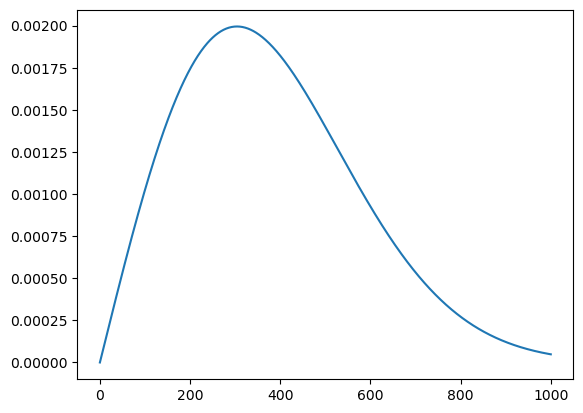

In [151]:
x = np.linspace(0, 1000, 1000)
y = diffDeflection(x)

fig, ax = plt.subplots(1, 1)

ax.plot(x, y)

In [154]:
def yield_func( theta):
    yield_hist = np.array([0, 10, 90, 100])
    sputterY = np.zeros_like(theta)
    indice = np.logical_and(theta > yield_hist[0], theta < yield_hist[1])
    indice |= np.logical_and(theta > yield_hist[2], theta < yield_hist[3])
    sputterY[indice] = 1
    return sputterY


In [155]:
yield_func(np.arange(100))

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1])